# Produktionsprogrammplanung Aufgabe 1

## Aufgabenstellung

Text

## Inputdaten

In [1]:
import pandas as pd
import qgrid

import ipywidgets as widgets
gropt = {'minVisibleRows': 2}


In [3]:
# Produktionskoeffizienten
a = pd.DataFrame()
a.loc['Schlafzimmer','Abteilung_I'] = 2
a.loc['Schlafzimmer','Abteilung_II'] = 2
a.loc['Schlafzimmer','Abteilung_III'] = 0
a.loc['Wohnzimmer','Abteilung_I'] = 4
a.loc['Wohnzimmer','Abteilung_II'] = 2
a.loc['Wohnzimmer','Abteilung_III'] = 3

qgrid_widget_a = qgrid.show_grid(a, grid_options = gropt)
qgrid_widget_a

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [4]:
# Kapazitaeten
r = pd.DataFrame()
r.loc['Abteilung_I','r'] = 160
r.loc['Abteilung_II','r'] = 180
r.loc['Abteilung_III','r'] = 150

qgrid_widget_r = qgrid.show_grid(r, grid_options = gropt)
qgrid_widget_r

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [5]:
# Weitere Inputdaten
data = pd.DataFrame()
data.loc['Schlafzimmer','Preis'] = 9000
data.loc['Schlafzimmer','Absatzhoechstmenge'] = 85
data.loc['Schlafzimmer','VariableStueckkosten'] = 7000
data.loc['Wohnzimmer','Preis'] = 19500
data.loc['Wohnzimmer','Absatzhoechstmenge'] = 50
data.loc['Wohnzimmer','VariableStueckkosten'] = 16000

qgrid_widget_data = qgrid.show_grid(data, grid_options = gropt)
qgrid_widget_data

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [6]:
# Dataframes aktualisieren
a = qgrid_widget_a.get_changed_df()
r = qgrid_widget_r.get_changed_df()
data = qgrid_widget_data.get_changed_df()

# Deckungsbeitrag
for x in data.index.tolist():
    data.loc[x,'DB'] = data.loc[x,'Preis'] - data.loc[x,'VariableStueckkosten']

print(a)
print()
print(r)
print()
print(data)

              Abteilung_I  Abteilung_II  Abteilung_III
Schlafzimmer          2.0           2.0            0.0
Wohnzimmer            4.0           2.0            3.0

                   r
Abteilung_I    160.0
Abteilung_II   180.0
Abteilung_III  150.0

                Preis  Absatzhoechstmenge  VariableStueckkosten      DB
Schlafzimmer   9000.0                85.0                7000.0  2000.0
Wohnzimmer    19500.0                50.0               16000.0  3500.0


## Loesen des Problems mit PuLP

In [7]:
import numpy as np
from pulp import *

Produkte = a.index.tolist()
Abteilungen = a.columns.tolist()

prob = pulp.LpProblem('Problem_MoebelAG', pulp.LpMaximize)

x = LpVariable.dicts('Anzahl', Produkte, lowBound=0)

prob += lpSum([x[i]*data.loc[i,'DB'] for i in Produkte]), "Zielfunktion"

for j in Abteilungen:
    prob += lpSum([x[i]* a.loc[i,j] for i in Produkte]) <= r.loc[j,'r'], "Kapazitaetsrestriktion_%s"%j
    
for i in Produkte:
    prob += x[i] <= data.loc[i,'Absatzhoechstmenge'], "Absatzrestriktion_%s"%i
    
print(prob)

Problem_MoebelAG:
MAXIMIZE
2000.0*Anzahl_Schlafzimmer + 3500.0*Anzahl_Wohnzimmer + 0.0
SUBJECT TO
Kapazitaetsrestriktion_Abteilung_I: 2 Anzahl_Schlafzimmer
 + 4 Anzahl_Wohnzimmer <= 160

Kapazitaetsrestriktion_Abteilung_II: 2 Anzahl_Schlafzimmer
 + 2 Anzahl_Wohnzimmer <= 180

Kapazitaetsrestriktion_Abteilung_III: 3 Anzahl_Wohnzimmer <= 150

Absatzrestriktion_Schlafzimmer: Anzahl_Schlafzimmer <= 85

Absatzrestriktion_Wohnzimmer: Anzahl_Wohnzimmer <= 50

VARIABLES
Anzahl_Schlafzimmer Continuous
Anzahl_Wohnzimmer Continuous



In [8]:
prob.writeLP("MoebelAG.lp")
prob.solve()

print("Status:", LpStatus[prob.status])

print("Erzielter Deckungsbeitrag = {:,.0f} GE".format(value(prob.objective)))

print()

for i in Produkte:
    print('Optimale Produktionsmenge {}: {:,.2f} ME'.format(i, x[i].varValue))

Status: Optimal
Erzielter Deckungsbeitrag = 160,000 GE

Optimale Produktionsmenge Schlafzimmer: 80.00 ME
Optimale Produktionsmenge Wohnzimmer: 0.00 ME


## Plotten

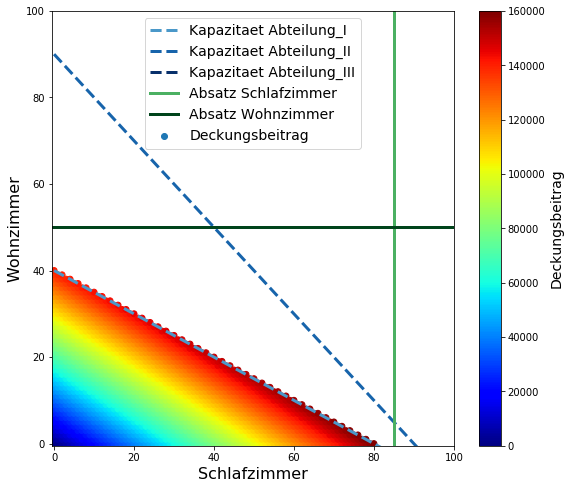

In [9]:
%matplotlib inline
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(9, 8))
s = np.linspace(0, 100)

# Kapazitätsrestriktionen
colors1 = plt.cm.Blues(np.linspace(0.6,1.0,3))
n = 0
for j in Abteilungen:    
    plt.plot(s,(r.loc[j,'r']-s*a.loc['Schlafzimmer',j])/a.loc['Wohnzimmer',j], lw=3,
             c=colors1[n], linestyle='dashed', label='Kapazitaet '+j)
    n += 1
    
# Absatzrestriktionen
colors2 = plt.cm.Greens(np.linspace(0.6,1.0,2))
plt.axvline(x=data.loc['Schlafzimmer','Absatzhoechstmenge'], lw=3,
            c=colors2[0],linestyle='solid', label='Absatz Schlafzimmer')
plt.axhline(y=data.loc['Wohnzimmer','Absatzhoechstmenge'], lw=3,
            c=colors2[1], linestyle='solid', label='Absatz Wohnzimmer')

# Zielfunktion plotten
pairs = [(x, y) for x in np.arange(101)
                for y in np.arange(101)
                if (x * a.loc['Schlafzimmer','Abteilung_I'] + y * a.loc['Wohnzimmer','Abteilung_I']) <= r.loc['Abteilung_I','r']
                and (x * a.loc['Schlafzimmer','Abteilung_II'] + y * a.loc['Wohnzimmer','Abteilung_II']) <= r.loc['Abteilung_II','r']
                and (x * a.loc['Schlafzimmer','Abteilung_III'] + y * a.loc['Wohnzimmer','Abteilung_III']) <= r.loc['Abteilung_III','r']         
                and x <= data.loc['Schlafzimmer','Absatzhoechstmenge']
                and y <= data.loc['Wohnzimmer','Absatzhoechstmenge']]

x1, x2 = np.hsplit(np.array(pairs), 2)
z = x1 * data.loc['Schlafzimmer','DB']  + x2 * data.loc['Wohnzimmer','DB']  # the objective function
plt.scatter(x1, x2, c=z, cmap='jet', label='Deckungsbeitrag', zorder=2)

# Diagramm erstellen
cb = plt.colorbar()
cb.set_label('Deckungsbeitrag', fontsize=14)
plt.xlabel('Schlafzimmer', fontsize=16)
plt.ylabel('Wohnzimmer', fontsize=16)
plt.xlim(-0.5, 100)
plt.ylim(-0.5, 100)
plt.legend(fontsize=14)
plt.show()